In [1]:
import re
import pandas as pd
from bokeh.io import output_notebook
from bokeh.plotting import curdoc
from bokeh.themes import Theme
from sklearn.feature_selection import VarianceThreshold
import eda_tools

output_notebook()
curdoc().theme = Theme("bokeh_theme.yaml")


Loading BokehJS ...

In [2]:
data = pd.read_csv("./data/train.csv")
data.columns = data.columns.str.lower()


# Exploração inicial.

A classificação dos clientes é dada pela variável "target". O valor "1" representa a classe positiva, que neste caso engloba os clientes _insatisfeitos_. O valor "0" então representa a classe negativa, dos clientes _satisfeitos_.

In [3]:
X = data.drop(columns=["target"])
y = data["target"]


O conjunto de dados contém 76_020 linhas (clientes) e 370 colunas (variáveis), sendo que todas as colunas são do tipo float64 (111) ou int64 (259).

In [4]:
X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 370 entries, id to var38
dtypes: float64(111), int64(259)
memory usage: 214.6 MB


Os valores de "id" são todos distintos (como era de se esperar) e não coincidem com o índice da tabela.

In [5]:
print(f"Número de 'id' distintos: {X['id'].nunique()}")

coinciding_indices = sum(X["id"] == X.index)
print(f"Número de 'id' que coincidem com o índice do data frame: {coinciding_indices}")


Número de 'id' distintos: 76020
Número de 'id' que coincidem com o índice do data frame: 0


Os índices estão uniformemente distribuídos. Isso provavelmente quer dizer que não são relevantes e podem ser descartados.

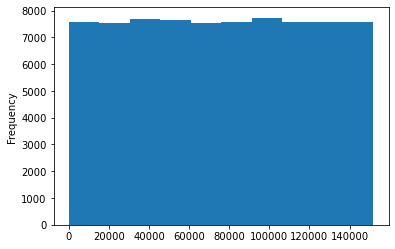

In [6]:
X["id"].plot.hist()
X = X.drop(columns=["id"])


Podemos ver que todas as variáveis deste conjunto contêm o termo "var" seguido de um número.

In [7]:
variables = []
no_var = 0
for feature in X.columns:
    result = re.search(r"var(\d+)", feature)
    if result is not None:
        var_number = int(result.group(1))
        variables.append(var_number)
    else:
        print(f"{feature} não contém 'var'.\n")
        no_var += 1
else:
    variables = sorted(set(variables))

print(
    f"Variáveis presentes: {variables}\n",
    f"Número de variáveis básicas no conjunto: {len(variables)}\n",
    f"Número de variáveis que não são função de 'var#': {no_var}",
    sep="\n",
)


Variáveis presentes: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]

Número de variáveis básicas no conjunto: 45

Número de variáveis que não são função de 'var#': 0


Também podemos ver a única variável que falta no intervalo que temos é a "var23".

In [8]:
for idx in range(1, variables[-1] + 1):
    if idx not in variables:
        print(f"'var{idx}' não é uma variável neste conjunto.")


'var23' não é uma variável neste conjunto.


Podemos ver que o conjunto é altamente desbalanceado, tendo apenas cerca de 3008 / 76_020 ~ 4% de clientes insatisfeitos. Com esse nível de desbalanceamento, não será adequado utilizar a acurácia como métrica.

In [9]:
print(
    "Número de clientes em cada classe:",
    y.value_counts(),
    sep="\n",
)


Número de clientes em cada classe:
0    73012
1     3008
Name: target, dtype: int64


As variáveis desta tabela não tem nomes claros devido à anonimização dos dados. Isso faz com que qualquer intuição a respeito delas seja muito difícil.

In [10]:
print(data.columns)


Index(['id', 'var3', 'var15', 'imp_ent_var16_ult1', 'imp_op_var39_comer_ult1',
       'imp_op_var39_comer_ult3', 'imp_op_var40_comer_ult1',
       'imp_op_var40_comer_ult3', 'imp_op_var40_efect_ult1',
       'imp_op_var40_efect_ult3',
       ...
       'saldo_medio_var33_hace2', 'saldo_medio_var33_hace3',
       'saldo_medio_var33_ult1', 'saldo_medio_var33_ult3',
       'saldo_medio_var44_hace2', 'saldo_medio_var44_hace3',
       'saldo_medio_var44_ult1', 'saldo_medio_var44_ult3', 'var38', 'target'],
      dtype='object', length=371)


Para ter alguma intuição sobre o conjunto de dados, nós podemos verificar a existência de variáveis que apresentem valores constantes para todos os clientes. Essas variáveis podem ser facilmente descartadas, já que não tem poder preditivo. As transformações do scikit-learn não retornam DataFrames, então é preciso de um pouco de trabalho para manter os nomes das colunas.

In [11]:
cols = X.columns
original_len = len(cols)
selector = VarianceThreshold()
selector.fit(X)
X = pd.DataFrame(selector.transform(X))
X.columns = cols[selector.get_support()]
new_len = len(X.columns)
num_elim_var = original_len - new_len
print(f"Número de variáveis eliminadas: {num_elim_var}")
print(f"Número de variáveis restantes: {new_len}")


Número de variáveis eliminadas: 34
Número de variáveis restantes: 335


Como ainda resta um número muito grande de variáveis (335) e elas são de difícil interpretação, podemos buscar quais delas são individualmente relevantes para a tarefa de classificação. Isso pode ser feito facilmente com uma árvore de decisão, utilizando as variáveis uma a uma.

É importante notar que, como as classes são desbalanceadas, o modelo não vai conseguir se ajustar bem naturalmente. Por isso devemos especificar que as classes devem receber pesos de maneira inversamente proporcional à sua predominância.

Vamos também utilizar árvores com apenas um nó, para tentar identificar variáveis que façam um divisão binária simples nos dados.

Como já comentado, o fato de o conjunto de dados ser tão desbalanceado jaz com que a acurácia não seja uma boa métrica. Por esse motivo, vamos analisar três outras figuras de mérito em conjunto: a sensibilidade, a especificidade e a área sob a curva ROC, que será usada para ordenar o DataFrame.

A última coluna do DataFrame abaixo apresenta o valor da variável que divide o conjunto de dados nas partes de classe negativa e positiva.

In [12]:
df, trees = eda_tools.create_trees(X, y, features=X.columns, random_state=101)

df


,feature,sensitivity,specificity,roc_auc,cutoff
164,saldo_var30,0.635188,0.731845,0.683516,2.45
297,saldo_medio_var5_ult1,0.675291,0.675845,0.675568,2.90
148,saldo_var5,0.686934,0.662791,0.674862,2.45
171,saldo_var42,0.636481,0.711771,0.674126,2.45
298,saldo_medio_var5_ult3,0.663648,0.678752,0.671200,1.94
...,...,...,...,...,...
139,num_var40_0,0.984476,0.011902,0.498189,1.50
71,ind_var40_0,0.984476,0.011902,0.498189,0.50
135,num_var37_med_ult2,0.975420,0.019636,0.497528,4.50
264,num_op_var39_comer_ult3,0.839586,0.154289,0.496938,1.50


Analisando esses resultados vemos que existem algumas variáveis que aparentam ter uma capacidade de classificação razoável por si só.

Por exemplo, vamos considerar a variável "saldo\_var30", que é a que possui a maior área sob a curva ROC. O gráfico mostra o percentual acumulado de clientes que tem um saldo de _até_ um certo valor (representado no eixo x). Podemos ver que a proporção de clientes nos dois grupos apresenta um salto grande de prevalência em torno do valor 0, mas o grupo insatisfeito aumenta muito mais acentuadamente. Isso significa que temos uma concentração proporcionalmente maior de clientes insatisfeitos. Em outras palavras, clientes insatisfeitos tendem a ter um _saldo menor_.

In [13]:
feature = df.iloc[0]
eda_tools.plot_feature_cumsum(X, y, feature["feature"], feature["cutoff"])


Também é interessante observar a coluna 'var15'. A sua distribuição de valores sugere que ela possa ser a idade do cliente. A árvore de decisão que treinamos encontrou uma fronteira de decisão no valor de 26.5, sendo que clientes abaixo dessa idade seriam classificados como satisfeitos.

In [14]:
feature = df.loc[1, :]
eda_tools.plot_feature_cumsum(
    X, y, feature["feature"], feature["cutoff"], x_range=(5, 60)
)


Dependendo do objetivo do projeto, uma simples árvore de decisão dessas já poderia ser suficiente. Como o nosso objetivo é alcançar um desempenho de 70%, precisamos buscar um modelo um pouco mais sofisticado.